In [1]:
import os
import pickle
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [ ]:
def summarize_experiment_metric(base_dir, algorithm, dataset, metric="test_accuracy"):
    """
    Computes mean and std of a specified metric (e.g., test_accuracy or test_loss) over seeds,
    grouped by damping and learning rate.

    Args:
        base_dir (str): Path to experiment results.
        algorithm (str): Algorithm name (e.g., 'Adam_CLARA').
        dataset (str): Dataset name (e.g., 'mnist').
        metric (str): Which metric to summarize ('test_accuracy', 'test_loss', etc.)

    Returns:
        str: Tabulated summary (learning rates as rows, damping values as columns).
    """
    # Pattern to extract metadata from folder name
    folder_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2})_(\d+)_([\d]+)_([0-9eE\.-]+)")

    # To hold results: {damping -> {lr -> [accuracies]}}
    results = defaultdict(lambda: defaultdict(list))

    for entry in os.listdir(base_dir):
        match = folder_pattern.match(entry)
        if not match:
            continue

        _, _, _, seed, damping = match.groups()
        dataset_path = os.path.join(base_dir, entry, dataset)

        if not os.path.isdir(dataset_path):
            continue

        for lr_folder in os.listdir(dataset_path):
            if not lr_folder.startswith("lr"):
                continue
            lr_value = lr_folder[2:]  # remove 'lr' prefix
            result_file = os.path.join(dataset_path, lr_folder, f"{algorithm}.pkl")

            if os.path.isfile(result_file):
                with open(result_file, 'rb') as f:
                    data = pickle.load(f)
                    value = data.get(metric)
                    if value is not None:
                        results[damping][lr_value].append(value)

    # Aggregate mean and std
    summary_stats = defaultdict(dict)
    for damping, lr_dict in results.items():
        for lr, vals in lr_dict.items():
            mean_val = np.mean(vals)
            std_val = np.std(vals)
            summary_stats[damping][lr] = (mean_val, std_val)

    # Format for tabulate: rows=LR, cols=Damping
    all_lrs = sorted({lr for d in summary_stats.values() for lr in d}, key=lambda x: float(x))
    all_dampings = sorted(summary_stats.keys(), key=lambda x: float(x))
    headers = ["LR \\ Damping"] + all_dampings
    table = []
    for lr in all_lrs:
        row = [lr]
        for damping in all_dampings:
            if lr in summary_stats[damping]:
                mean, std = summary_stats[damping][lr]
                row.append(f"{mean:.4f} ± {std:.4f}")
            else:
                row.append("-")
        table.append(row)

    title = f"{metric.replace('_', ' ').capitalize()} for {algorithm} on {dataset}"
    table_str = tabulate(table, headers=headers, tablefmt="grid")

    print(title)
    print(table_str)

    # return f"{title}\n{table_str}"
    return summary_stats

In [ ]:
summarize_experiment_metric(
    base_dir="TM_Experiments/results/",
    algorithm="Adam_CLARA",
    dataset="mnist",
    metric="test_accuracy"
)

In [2]:
def summarize_metric_sweep_lr(base_dir, algorithms, datasets, lr_values, metric="test_accuracy"):
    """
    Computes mean and std of a specified metric (e.g., test_accuracy or test_loss) over seeds,
    for each learning rate in `lr_values`. Displays results by algorithm (rows) and dataset (columns),
    grouped by learning rate with the LR value shown only once per block.

    Returns:
        summary_stats: dict[lr][algorithm][dataset] = (mean, std)
    """

    folder_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2})_(\d+)_([\d]+)")

    # Store results: {lr -> algorithm -> dataset -> values}
    summary_stats = defaultdict(lambda: defaultdict(dict))
    all_rows = []

    for lr_value in lr_values:
        results = defaultdict(lambda: defaultdict(list))

        for entry in os.listdir(base_dir):
            if not folder_pattern.match(entry):
                continue
            run_dir = os.path.join(base_dir, entry)

            for dataset in datasets:
                dataset_path = os.path.join(run_dir, dataset)
                lr_folder = os.path.join(dataset_path, f"lr{lr_value}")
                if not os.path.isdir(lr_folder):
                    continue

                for algorithm in algorithms:
                    result_file = os.path.join(lr_folder, f"{algorithm}.pkl")
                    if os.path.isfile(result_file):
                        with open(result_file, 'rb') as f:
                            data = pickle.load(f)
                            val = data.get(metric)
                            if val is not None:
                                results[algorithm][dataset].append(val)

        # Compute mean/std for this learning rate
        for algorithm in algorithms:
            row = [lr_value if algorithm == algorithms[0] else "", algorithm]
            for dataset in datasets:
                vals = results[algorithm][dataset]
                if vals:
                    mean_val = np.mean(vals)
                    std_val = np.std(vals)
                    summary_stats[lr_value][algorithm][dataset] = (mean_val, std_val)
                    row.append(f"{mean_val:.4f} ± {std_val:.4f}")
                else:
                    summary_stats[lr_value][algorithm][dataset] = None
                    row.append("-")
            all_rows.append(row)

    # Build headers
    headers = ["LR", "Algorithm"] + datasets
    table_str = tabulate(all_rows, headers=headers, tablefmt="fancy_grid")
    print(table_str)
    return summary_stats

In [3]:
def plot_algorithm_performance(summary_stats, algorithms, datasets, lr_values, metric_name="Test Accuracy"):
    """
    Plot bar charts with error bars showing mean and std for each algorithm at different learning rates,
    one plot per dataset, with improved spacing, consistent y-axis, a horizontal line for best performance,
    and transparency on non-best bars. Each algorithm is assigned a consistent color.
    """
    def get_algorithm_colors(algorithms):  # TODO: Take out. Define only in one place
        """
        Returns a dictionary mapping each algorithm to a distinct color from the 'tab10' colormap.
        """
        num_colors = len(algorithms)
        colormap = plt.get_cmap('tab10', num_colors)
        color_map = {algorithm: colormap(i) for i, algorithm in enumerate(algorithms)}
        return color_map

    num_lrs = len(lr_values)
    num_algos = len(algorithms)
    bar_width = 0.15
    group_spacing = 0.4  # space between groups
    total_group_width = num_algos * bar_width + group_spacing
    x = np.arange(num_lrs) * total_group_width

    color_map = get_algorithm_colors(algorithms)

    for dataset in datasets:
        plt.figure(figsize=(12, 6))

        all_means = []  # store all means to compute the best one

        # First, gather all means to find the best one
        for algorithm in algorithms:
            for lr in lr_values:
                stats = summary_stats.get(lr, {}).get(algorithm, {}).get(dataset)
                if stats is not None:
                    mean, _ = stats
                    all_means.append((mean, algorithm, lr))

        if not all_means:
            continue  # skip empty plots

        # Find the best performing (mean) algorithm-lr pair
        best_mean, best_algo, best_lr = max(all_means, key=lambda x: x[0])

        for i, algorithm in enumerate(algorithms):
            means = []
            stds = []
            alphas = []

            for lr in lr_values:
                stats = summary_stats.get(lr, {}).get(algorithm, {}).get(dataset)
                if stats is not None:
                    mean, std = stats
                else:
                    mean, std = 0, 0
                means.append(mean)
                stds.append(std)

                # Make best bar opaque, others semi-transparent
                if algorithm == best_algo and lr == best_lr:
                    alphas.append(1.0)
                else:
                    alphas.append(0.5)

            x_pos = x + i * bar_width
            bars = plt.bar(x_pos, means, width=bar_width, label=algorithm, yerr=stds,
                           capsize=5, color=color_map[algorithm])

            # Adjust alpha bar by bar
            for bar, a in zip(bars, alphas):
                bar.set_alpha(a)

        # Add horizontal line at best performance
        plt.axhline(y=best_mean, color='gray', linestyle='--', linewidth=1)
        plt.text(x[0] - bar_width * 3.9, best_mean, f"{best_mean:.2f}", va='center', ha='right', color='gray')

        # Plot styling
        plt.xticks(x + (num_algos / 2 - 0.5) * bar_width, lr_values)
        plt.xlabel("Learning Rate")
        plt.ylabel(metric_name)
        plt.title(f"{metric_name} on {dataset}")
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [4]:
summary = summarize_metric_sweep_lr(
    base_dir="TM_Experiments/results/",
    algorithms=["SGD_CLARA", "SGD_CLARA_us", "SGD", "Adam_CLARA", "Adam_CLARA_us", "Adam", "D-Adaptation"],
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],  # must match folder name exactly
    metric="test_accuracy"
)


╒═══════╤═══════════════╤═════════════════╤════════╤════════╤══════════╤══════════════════╤══════════════════╤═══════════╤════════════╕
│ LR    │ Algorithm     │ breast_cancer   │ iris   │ wine   │ digits   │ mnist            │ fmnist           │ cifar10   │ cifar100   │
╞═══════╪═══════════════╪═════════════════╪════════╪════════╪══════════╪══════════════════╪══════════════════╪═══════════╪════════════╡
│ 1e-06 │ SGD_CLARA     │ -               │ -      │ -      │ -        │ 31.6760 ± 7.8479 │ 72.3920 ± 0.6505 │ -         │ -          │
├───────┼───────────────┼─────────────────┼────────┼────────┼──────────┼──────────────────┼──────────────────┼───────────┼────────────┤
│       │ SGD_CLARA_us  │ -               │ -      │ -      │ -        │ 46.5280 ± 6.2373 │ 73.5020 ± 0.5274 │ -         │ -          │
├───────┼───────────────┼─────────────────┼────────┼────────┼──────────┼──────────────────┼──────────────────┼───────────┼────────────┤
│       │ SGD           │ -               │ -   

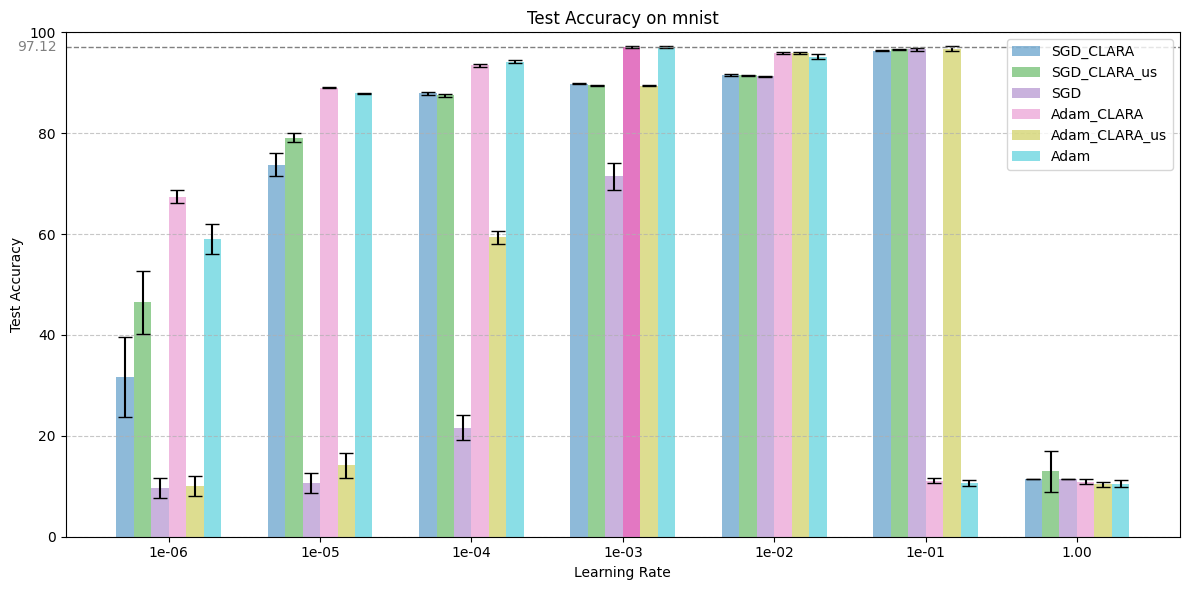

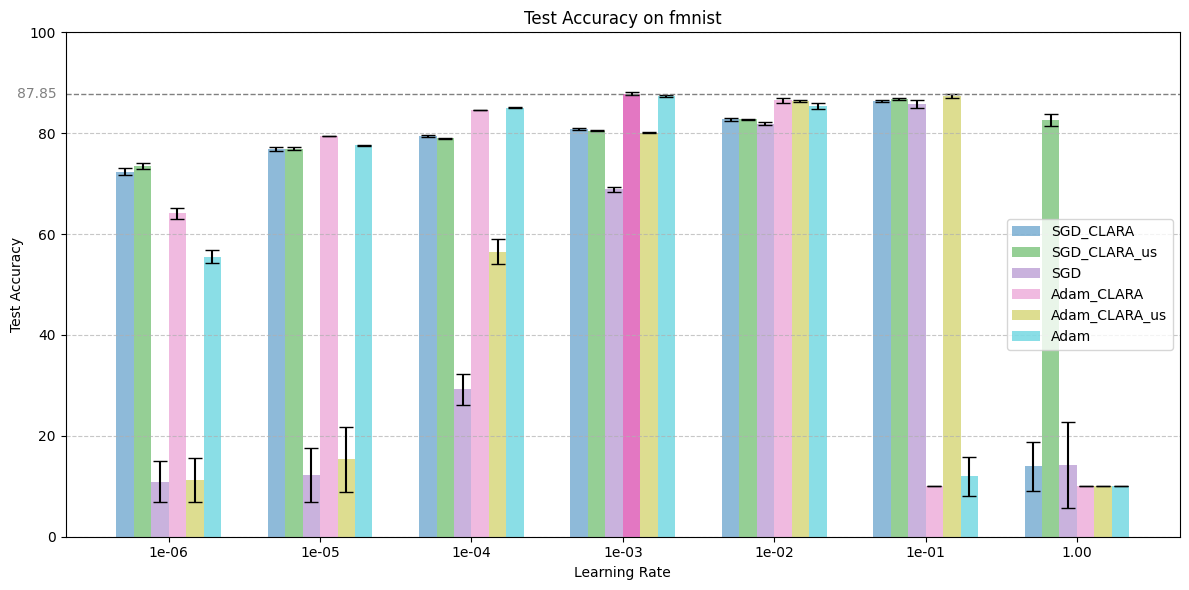

In [5]:
plot_algorithm_performance(
    summary_stats=summary,  # from your earlier function
    algorithms=["SGD_CLARA", "SGD_CLARA_us", "SGD", "Adam_CLARA", "Adam_CLARA_us", "Adam"],
    datasets=["mnist", "fmnist"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],
    metric_name="Test Accuracy"
)